# Quantum Harmonic Oscillator Experiments

In [1]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import pickle
import json

from qiskit_aer import Aer
from qiskit.converters import circuit_to_dag
from qiskit.compiler import transpile

In [2]:
from open_quantum_systems.qho import *
from open_quantum_systems.math_util import *
from open_quantum_systems.lindblad import simulate_lindblad_trajectory

### Data Directory

In [3]:
DATA_DIR = './data'

### Backend configurations:

In [4]:
# Aer simulator configuration:
aer_backend = Aer.get_backend('aer_simulator')
aer_transpile_options = {
    'optimization_level' : 3,
    'approximation_degree' : 0.975
}

# IonQ configuration:
ionq_transpile_options = {
    'optimization_level' : 3,
    'approximation_degree' : 0.975
}

# IonQ Simulator configuration:
ionq_simulator_options = {
    "error-mitigation": {
        "debias": True
    },
        "noise": {
        "model": "harmony",
        "seed": 1000
    }
}

# IonQ QPU configuration:
ionq_real_qpu_options = {
    "error-mitigation": {
        "debias": True
    }
}

def save_data(job_data, filename):
    with open(os.path.join(DATA_DIR, filename), 'wb') as f:
        pickle.dump(job_data, f)

def load_data(filename):
    with open(os.path.join(DATA_DIR, filename), 'rb') as f:
        return pickle.load(f)

def save_json_data(job_array, filename):
    with open(os.path.join(DATA_DIR, filename), 'w') as f:
        f.write(json.dumps(job_array))

## 📝 **Configure Job Submission Here** 📝

To submit jobs on real quantum hardware, you will need to configure the following variables:

1. **`quantum_backend`**: Qiskit backend that will be targeted for transpilation. If the provider has a Qiskit backend, set this variable to the correct backend.
2. **`quantum_transpile_options`**: Options for the Qiskit transpiler. I would recommend the following options:
  * `{'optimization_level' : 3, 'approximation_degree' : 0.975 }`

In addition, you will also need to define the following functions:

3. **`launch_quantum_job(circuits, shots)`**:
    * This function submits a list of circuits to the provider, running each circuit with the given number of shots. The function must return a list of unique job identifiers (`job_array`), which can be saved and later used to retrieve the jobs from the provider. Currently this function returns an Aer job object to simulate submission to a server. You will need to change this to instead return a list of unique job ids for each submitted circuit (IDs in string format are preferred).

4. **`get_quantum_job_results(circuits, shots)`**:
    * This function retrieves the results corresponding to a list of unique job identifiers (i.e. the same `job_array` list that was returned from `launch_quantum_job`). The function must return a list of measurement count dictionaries corresponding to each unique id in `job_array`. For example, these dictionaries take the form: `{'00': 721, '01': 1327}`. This dictionary can easily be retrieved from a qiskit job object using the `result.get_counts()` function.
          

In [5]:
# 1. This is the backend that is targeted by Qiskit's transpiler/optimizer
quantum_backend = aer_backend

# 2. These are the transpiler options:
quantum_transpile_options = aer_transpile_options

# 3. This function submits a list of circuits and submits them to the provider and
#    returns a list of unique job ids.
def launch_quantum_job(circuits, shots):
    job_array = [
        quantum_backend.run(c, shots=shots) for c in circuits
    ]
    
    return job_array # <-- This should be a list of unique job ids (preferably strings)

# 4. This function retrieves the results jobs from the provider based on a list of job ids.
def get_quantum_job_results(job_array):

    result_counts = [
        job.result().get_counts()
        for job in job_array
    ]
    
    return result_counts # <-- This should be a list of measurement count dictionaries

quantum_primitive_kwargs = {
    'launch_job_fn' : launch_quantum_job,
    'get_result_fn' : get_quantum_job_results
}

## Helpful Functions:

In [6]:
from scipy.linalg import sqrtm

def fidelity(rho_a, rho_b):

    rho_a = np.array(rho_a)
    rho_b = np.array(rho_b)
    
    a_rhos = rho_a.reshape(-1, *rho_a.shape[-2:])
    a_rhos /= np.trace(a_rhos, axis1=-2, axis2=-1).reshape((-1,1,1))
    b_rhos = rho_b.reshape(-1, *rho_b.shape[-2:])
    b_rhos /= np.trace(b_rhos, axis1=-2, axis2=-1).reshape((-1,1,1))
    
    t = np.array([
        np.trace(sqrtm(sqrtm(A)@B@sqrtm(A)), axis1=-2, axis2=-1)
        for A, B in zip(a_rhos, b_rhos)
    ])
    return np.abs(t**2).reshape(rho_a.shape[:-2])

def invert_uniform_pc(rho_a, _lambda=0.5):

    assert(0 <= _lambda < 1)
    
    rho_a = np.array(rho_a)
    a_rhos = rho_a.reshape(-1, *rho_a.shape[-2:])
    n = rho_a.shape[-1]
    
    _inv = lambda x : np.maximum(0, x-_lambda/n) / np.sum(np.maximum(0, x-_lambda/n))

    rho_sharpened = np.array([
        U @ np.diag(_inv(w)) @ U.conj().T
        for w, U in zip(*np.linalg.eigh(rho_a))
    ])
    
    return rho_sharpened.reshape(rho_a.shape)

def classical_entropy(p):
    p = np.maximum(p, 0.0)
    return -np.sum(p*np.log(np.maximum(p, 1e-20)))

def entropy(rho_a):
    rho_a = np.array(rho_a)
    a_rhos = rho_a.reshape(-1, *rho_a.shape[-2:])
    s = np.array([
        classical_entropy(np.linalg.eigvalsh(rho))
        for rho in a_rhos
    ])
    return s.reshape(rho_a.shape[:-2])

In [7]:
from itertools import combinations_with_replacement
from open_quantum_systems.math_util import *
from scipy.optimize import nnls

def fit_pauli_channel(rho, rho_target):
    rho, rho_target = np.array(rho), np.array(rho_target)

    A = []
    n_qubits = int(np.log2(rho.shape[-1]))
    pauli_strings = list(enumerate_pauli_strings(n_qubits))
    for ps in pauli_strings:
        s = make_pauli_operator(ps)
        rho_a = s @ rho @ s.conj().T
        A.append(np.hstack([rho_a.flatten().real, rho_a.flatten().imag]))

    A = np.array(A).T
    b = np.hstack([rho_target.flatten().real, rho_target.flatten().imag])
    p, err = nnls(A,b.T)
    p = np.real_if_close(p)
    channel_dict = { ps : pi for ps,pi in zip(pauli_strings,p) }

    return channel_dict, err

def invert_pauli_channel(rho_trajectory, channel_dict, positive_definite=True, renormalize=True):

    rho_trajectory = np.array(rho_trajectory)

    n = rho_trajectory.shape[-1]**2
    A = np.zeros((n,n),dtype=np.complex128)
    for ps, weight in channel_dict.items():
        if weight > 1e-8:
            s = make_pauli_operator(ps)
            A += weight*np.kron(s,s.conj())

    A_pinv = np.linalg.pinv(A)

    rho_inv_trajectory = []
    for rho in rho_trajectory:
        rho_inv = (A_pinv @ rho.flatten()).reshape(rho.shape)

        if positive_definite:
            w, U = np.linalg.eigh(rho_inv)
            w[w < 0.0] = 0
            rho_inv = U @ np.diag(w) @ U.conj().T

        if renormalize:
            rho_inv /= np.trace(rho_inv)
        
        rho_inv_trajectory.append(rho_inv)

    return np.array(rho_inv_trajectory)

### Test Pauli Channel Functions:

In [8]:
rho_test = np.array([[0.5,0.5],[0.5,0.5]])
rho_test_target = np.array([[0.5,0.25],[0.25,0.5]])

channel_dict, err = fit_pauli_channel(rho_test, rho_test_target)
print(channel_dict, err)

rho_inv = invert_pauli_channel([rho_test_target], channel_dict)
print(rho_inv)

{'I': np.float64(0.75), 'Z': np.float64(0.25), 'X': np.float64(0.0), 'Y': np.float64(0.0)} 0.0
[[[0.5+0.j 0.5+0.j]
  [0.5+0.j 0.5+0.j]]]


## Experiment Parameters:

In [9]:
hbar = 1./(2*np.pi)
omega = 2*np.pi
gamma = 1.0
cat_gamma = 0.6
mass = 1.0
t_range = (0,3)
cat_t_range = (0,2)

In [10]:
n_qubits = 2
n_benchmark_trajectory_samples = 10
n_trajectory_samples = 19
n_cat_trajectory_samples = 9

n_shots = 1000

initial_state = \
    np.array([0, 0, 1.j, 1], 
             dtype=np.complex128)/np.sqrt(2)

cat_alpha = 1.2
initial_cat_state = qho_cat_state(alpha=cat_alpha, n_qubits=n_qubits)

In [11]:
sim = QHOSimulation(n_qubits=2, kraus_order=3, hbar=hbar, omega=omega, gamma=gamma)
cat_sim = QHOSimulation(n_qubits=2, kraus_order=3, hbar=hbar, omega=omega, gamma=cat_gamma)

## Experiment 1:
Density Matrix Simulation (Excited Non-Stationary State):

In [12]:
rho_t = np.linspace(*t_range, n_trajectory_samples)
rho_t_classical = np.linspace(*t_range, 1000)

### 1. Run Ideal Simulations:

In [13]:
rho_simulated = sim.simulate_pure_state_density_evolution(
    pure_state=initial_state,
    t=rho_t,
    backend=aer_backend,
    shots=n_shots,
    masking=True,
    renormalize=False,
    transpile_options=aer_transpile_options,
)

rho_classical_simulated = sim.simulate_classical_density_matrix_evolution(
    initial_state=initial_state,
    t=rho_t_classical
)

### 2. Submit Jobs:

In [14]:
# rho_noisy_jobs = sim.simulate_pure_state_density_evolution(
#     pure_state=initial_state,
#     t=rho_t,
#     backend=quantum_backend,
#     shots=n_shots,
#     masking=True,
#     renormalize=False,
#     transpile_options=quantum_transpile_options,
#     primitive_kwargs=quantum_primitive_kwargs | dict(submit_jobs_only=True)
# )

**Note**: The following cell will fail to run if you are using the Aer-based `launch_job` function, but you should still be able to run the rest of the notebook. If you have properly defined the `launch_job` function it will save the ids of submitted jobs so you can load them later on.

In [15]:
#save_data(rho_noisy_jobs, 'qho_job.pkl')

### 3. Retrieve Job Results: 

In [16]:
#rho_noisy_jobs = load_data('qho_job.pkl')

In [17]:
# rho_noisy = sim.simulate_pure_state_density_evolution(
#     pure_state=initial_state,
#     t=rho_t,
#     backend=quantum_backend,
#     shots=n_shots,
#     masking=True,
#     renormalize=False,
#     transpile_options=quantum_transpile_options,
#     primitive_kwargs=quantum_primitive_kwargs | dict(submitted_jobs_data=rho_noisy_jobs)
# )

In [18]:
#save_data(rho_noisy, 'qho_data.pkl')

### 4. Visualize Job Results:

In [19]:
rho_noisy = load_data('qho_data_ionq.pkl')

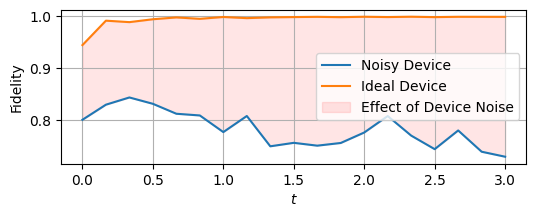

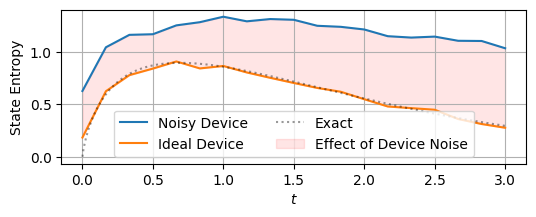

In [20]:
rho_exact = sim.simulate_classical_density_matrix_evolution(
    initial_state=initial_state,
    t=rho_t
)

fidelity_noisy = fidelity(rho_noisy, rho_exact)
fidelity_simulated = fidelity(rho_simulated, rho_exact)

plt.figure(figsize=(6,2))
plt.grid()
plt.plot(rho_t, fidelity_noisy, label='Noisy Device')

plt.plot(rho_t, fidelity_simulated, label='Ideal Device')
plt.fill_between(rho_t, fidelity_noisy, fidelity_simulated, color='r', alpha=0.1, label='Effect of Device Noise')
plt.legend()
plt.ylabel('Fidelity')
plt.xlabel(r'$t$')
plt.show()

plt.figure(figsize=(6,2))
plt.grid()
plt.plot(rho_t, entropy(rho_noisy), label='Noisy Device')
plt.plot(rho_t, entropy(rho_simulated), label='Ideal Device')
plt.plot(rho_t_classical, entropy(rho_classical_simulated), 'k:', alpha=0.4, label='Exact')
plt.fill_between(rho_t, entropy(rho_simulated), entropy(rho_noisy), color='r', alpha=0.1, label='Effect of Device Noise')
plt.ylabel('State Entropy')
plt.xlabel(r'$t$')
plt.legend(ncol=2, loc='lower center')
plt.show()

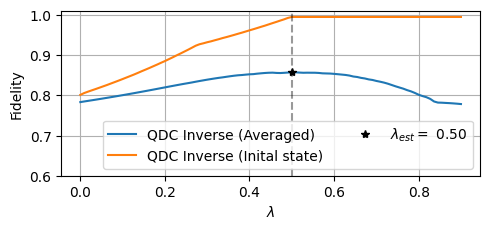

In [21]:
lambda_vals = np.linspace(0.0, 0.9, 100)

lambda_fidelities = np.array([
    fidelity(invert_uniform_pc(rho_noisy, l),rho_exact)
    for l in lambda_vals
])


lambda_opt_idx = np.argmax(lambda_fidelities[:,0], axis=-1)
lambda_opt = lambda_vals[lambda_opt_idx]
lambda_opt_fidelities = lambda_fidelities[lambda_opt_idx]
lambda_opt_avg_F = np.mean(lambda_opt_fidelities)

plt.figure(figsize=(5,2.4))
plt.grid()
plt.plot(lambda_vals, np.mean(lambda_fidelities, axis=-1), label='QDC Inverse (Averaged)')
plt.plot(lambda_vals, lambda_fidelities[:,0], label='QDC Inverse (Inital state)')
plt.ylim((0.6, 1.01))
plt.axvline(lambda_opt, linestyle='--', color='k', alpha=0.4)
plt.plot([lambda_opt],[lambda_opt_avg_F], 'k*', label=r'$\lambda_{est}=$ ' + f'{lambda_opt:.2f}')
plt.ylabel('Fidelity')
plt.xlabel(r'$\lambda$')
plt.legend(ncol=2,loc='lower right')
plt.tight_layout()
plt.show()


In [22]:
pc_fit, err = fit_pauli_channel(rho_exact, rho_noisy)
rho_inverted = invert_pauli_channel(rho_noisy, pc_fit, positive_definite=True)

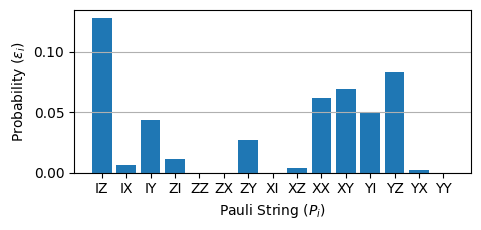

In [23]:
labels = list(pc_fit.keys())[1:]
labels_x = np.arange(len(labels))
coeffs = list(pc_fit.values())[1:]


plt.figure(figsize=(5,2.4))
plt.xticks(labels_x, labels=labels)
plt.grid(axis='y')
plt.bar(labels_x, coeffs, label=labels)
plt.xlabel(r'Pauli String ($P_i$)')
plt.ylabel(r'Probability ($\varepsilon_i$)')
plt.tight_layout()
plt.show()

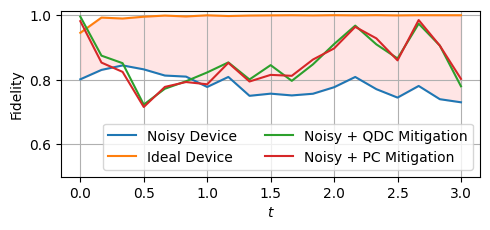

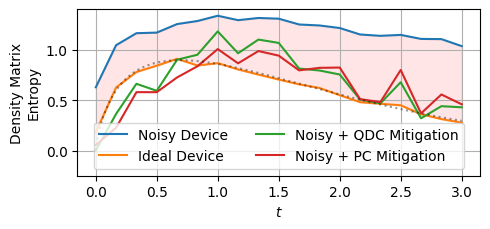

In [24]:
pc_fit, err = fit_pauli_channel(rho_exact, rho_noisy)
rho_inverted = invert_pauli_channel(rho_noisy, pc_fit, positive_definite=True)

rho_uniform = invert_uniform_pc(rho_noisy, lambda_opt)

fidelity_inverted = fidelity(rho_inverted, rho_exact)
fidelity_uniform = fidelity(rho_uniform, rho_exact)


plt.figure(figsize=(5,2.4))
plt.grid()
plt.plot(rho_t, fidelity_noisy, label='Noisy Device')
plt.plot(rho_t, fidelity_simulated, label='Ideal Device')
plt.plot(rho_t, lambda_opt_fidelities, label='Noisy + QDC Mitigation')
plt.plot(rho_t, fidelity_inverted, label='Noisy + PC Mitigation')
plt.ylim(0.5,None)
plt.fill_between(rho_t, fidelity_noisy, fidelity_simulated, color='r', alpha=0.1)
plt.legend(loc='lower right', ncol=2)
plt.ylabel('Fidelity')
plt.xlabel(r'$t$')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,2.4))
plt.grid()
plt.plot(rho_t, entropy(rho_noisy), label='Noisy Device')
plt.plot(rho_t, entropy(rho_simulated), label='Ideal Device')
plt.plot(rho_t, entropy(rho_uniform), label='Noisy + QDC Mitigation')
plt.plot(rho_t, entropy(rho_inverted), label='Noisy + PC Mitigation')

plt.plot(rho_t_classical, entropy(rho_classical_simulated), 'k:', alpha=0.4)
plt.fill_between(rho_t, entropy(rho_simulated), entropy(rho_noisy), color='r', alpha=0.1)
plt.ylabel('Density Matrix\nEntropy')
plt.xlabel(r'$t$')
plt.ylim(-0.25,None)
plt.legend(ncol=2, loc='lower center')
plt.tight_layout()
plt.show()

In [25]:
rho_mitigated = invert_uniform_pc(rho_noisy, lambda_opt)

X_classical = np.trace(
    sim.position_operator(m=mass, unitless=True)@rho_classical_simulated, 
    axis1=-2, axis2=-1).real

P_classical = np.trace(
    sim.momentum_operator(m=mass, unitless=True)@rho_classical_simulated,
    axis1=-2, axis2=-1).real

X_noisy = np.trace(sim.position_operator(m=mass, unitless=True)@rho_mitigated, 
                   axis1=-2, axis2=-1).real
P_noisy = np.trace(sim.momentum_operator(m=mass, unitless=True)@rho_mitigated, 
                   axis1=-2, axis2=-1).real

X = np.trace(sim.position_operator(m=mass, unitless=True)@rho_simulated, axis1=-2, axis2=-1).real
P = np.trace(sim.momentum_operator(m=mass, unitless=True)@rho_simulated, axis1=-2, axis2=-1).real

In [26]:
from scipy.interpolate import interp1d
    

def damped_harmonic_spline(t, omega, x,y):
    logr = np.log(np.sqrt(x**2+y**2))
    theta_0 = np.arctan2(y[0],x[0])
    r_spline = lambda s : np.exp(np.interp(s,t,logr))
    return lambda t : (r_spline(t)*np.cos(omega*t+theta_0), r_spline(t)*np.sin(omega*t+theta_0))

xp_traj_spline = damped_harmonic_spline(rho_t, -sim.omega, X_noisy, P_noisy)
X_interpolated, P_interpolated = xp_traj_spline(rho_t_classical)

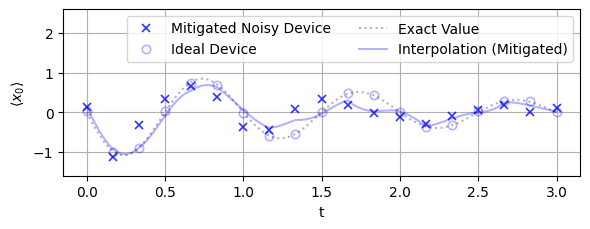

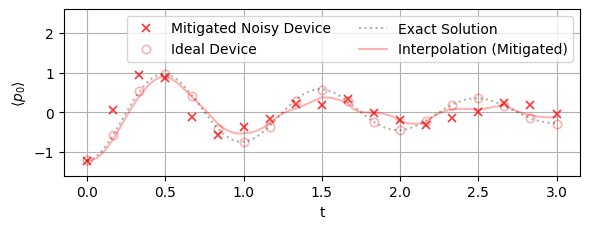

In [27]:

x_range=(-1.6,2.6)
p_range=(-1.6,2.6)

plt.figure(figsize=(6,2.4))
plt.plot(rho_t, X_noisy, 'bx', fillstyle='none', alpha=0.8, markeredgewidth=1.2, label='Mitigated Noisy Device')
plt.plot(rho_t, X, 'bo', fillstyle='none', markeredgewidth=1.2, alpha=0.3, label='Ideal Device')
plt.plot(rho_t_classical, X_classical, 'k:', label='Exact Value', alpha=0.3)
plt.plot(rho_t_classical, X_interpolated, 'b-', label='Interpolation (Mitigated)', alpha=0.3)

plt.ylabel(r'$\langle x_0 \rangle$')
plt.xlabel('t')
plt.legend(loc='upper right', ncol=2)
plt.grid()
plt.ylim(x_range)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,2.4))
plt.plot(rho_t, P_noisy, 'rx', fillstyle='none', alpha=0.8, markeredgewidth=1.2, label='Mitigated Noisy Device')
plt.plot(rho_t, P, 'ro', fillstyle='none', markeredgewidth=1.2, alpha=0.3, label='Ideal Device')
plt.plot(rho_t_classical, P_classical, 'k:', label='Exact Solution', alpha=0.3)
plt.plot(rho_t_classical, P_interpolated, 'r-', label='Interpolation (Mitigated)', alpha=0.3)
plt.ylabel(r'$\langle p_0 \rangle$')
plt.xlabel('t')
plt.legend(loc='upper right', ncol=2)
plt.grid()
plt.ylim(p_range)
plt.tight_layout()
plt.show()

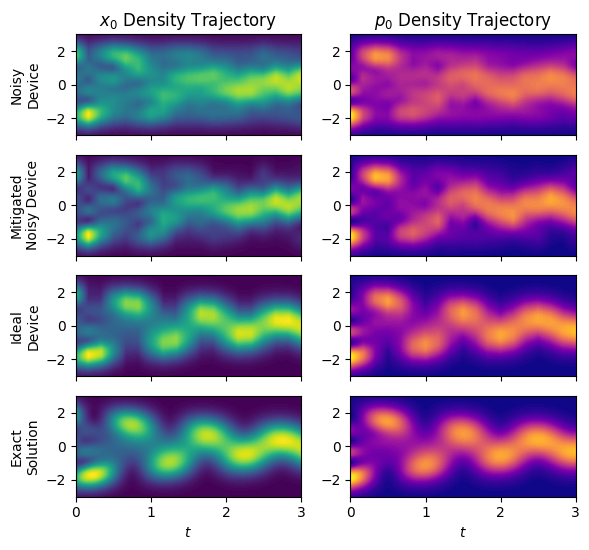

In [28]:
x_range2 = (-3,3)
p_range2 = (-3,3)

#fig, axes = plt.subplots(4,2, figsize=(8,5.6))
fig, axes = plt.subplots(4,2, figsize=(6,5.6)) # <-- Narrow


#plt.title('Noisy Quantum Computation')
sim.plot_position_density_trajectory(rho_t, rho_noisy,
                                     m=mass,
                                     xlim=x_range2,
                                     ax=axes[0,0],
                                     cmap='viridis',
                                     unitless=True)

#plt.title('Mitigated Quantum Computation')
sim.plot_position_density_trajectory(rho_t, rho_mitigated,
                                     m=mass,
                                     xlim=x_range2,
                                     ax=axes[1,0],
                                     cmap='viridis',
                                     unitless=True)

#plt.title('Ideal Quantum Computation')
sim.plot_position_density_trajectory(rho_t, rho_simulated, 
                                     m=mass,
                                     xlim=x_range2,
                                     ax=axes[2,0],
                                     cmap='viridis',
                                     unitless=True)

#plt.title('Exact Lindblad Solution')
sim.plot_position_density_trajectory(rho_t_classical, rho_classical_simulated,
                                     m=mass,
                                     xlim=x_range2,
                                     ax=axes[3,0],
                                     cmap='viridis',
                                     unitless=True)

#plt.title('Noisy Quantum Computation')
sim.plot_momentum_density_trajectory(rho_t, rho_noisy,
                                     m=mass, 
                                     plim=p_range2, 
                                     ax=axes[0,1],
                                     unitless=True)

#plt.title('Mitigated Quantum Computation')
sim.plot_momentum_density_trajectory(rho_t, rho_mitigated,
                                     m=mass,
                                     plim=p_range2, 
                                     ax=axes[1,1],
                                     unitless=True)

#plt.title('Ideal Quantum Computation')
sim.plot_momentum_density_trajectory(rho_t, rho_simulated, 
                                     m=mass, 
                                     plim=p_range2, 
                                     ax=axes[2,1],
                                     unitless=True)

#plt.title('Exact Lindblad Solution')
sim.plot_momentum_density_trajectory(rho_t_classical, rho_classical_simulated,
                                     m=mass, 
                                     plim=p_range2, 
                                     ax=axes[3,1],
                                     unitless=True)

for ax in axes[:-1,0]:
    ax.set_xticklabels([])
    ax.set_xlabel(None)
for ax in axes[:-1,1]:
    ax.set_xticklabels([])
    ax.set_xlabel(None)

axes[0,0].set_ylabel('Noisy\nDevice')
axes[1,0].set_ylabel('Mitigated\nNoisy Device')
axes[2,0].set_ylabel('Ideal\nDevice')
axes[3,0].set_ylabel('Exact\nSolution')
for ax in axes[:,1]:
    ax.set_ylabel(None)

axes[0,0].set_title('$x_0$ Density Trajectory')
axes[0,1].set_title('$p_0$ Density Trajectory')

plt.tight_layout()
plt.show()

In [29]:
# noisy_anim = sim.plot_wigner_distribution_animation(rho_t, np.array(rho_simulated),
#                                                   xlim=(-3.5,3.5), plim=(-3.5,3.5),
#                                                   mesh_size=(50,50),
#                                                   frame_interval=1000)
# plt.title('Oscillating State')

In [30]:
# noisy_anim = sim.plot_wigner_distribution_animation(rho_t, np.array(rho_mitigated),
#                                                   xlim=(-3.5,3.5), plim=(-3.5,3.5),
#                                                   mesh_size=(50,50),
#                                                   frame_interval=1000)
# plt.title('Oscillating State')

In [31]:
def plot_wigner_trajectory(X, P, W_t, t_vals, title=None, rows=3, cols=3, figsize=None, axs=None, t_labels=True, rcol_labels=False, t_step=1):
    if figsize is None:
        figsize = (1.4*cols,1.4*rows)

    if axs is None:
        fig, axs = plt.subplots(rows, cols, figsize=figsize)
    else:
        rows = axs.shape[0]
        cols = axs.shape[1]

    for i, ax in enumerate(axs.flatten()):
        t = t_vals[i*t_step]
        zlim = max(np.abs(np.min(W_t)), np.abs(np.max(W_t)))
        ax.grid(alpha=0.8)
        cax = ax.pcolormesh(X,P, W_t[i*t_step], cmap='seismic', vmin=-zlim, vmax=zlim, shading='gouraud')
        if t_labels:
            ax.text(0.5,0.9,r'$t$ = '+f'{t:.3f}', transform=ax.transAxes, ha="center", 
                                bbox=dict(boxstyle='round', facecolor='white'))
        ax.set_xticks([-2,0,2])
        ax.set_yticks([-2,0,2])
        if rcol_labels:
            ax.yaxis.tick_right()
        
        if (i//cols) == rows-1:
            ax.set_xlabel(r'$x_0$')
        else:
            ax.set_xticklabels([])

        if not rcol_labels and (i%cols) == 0:
            ax.set_ylabel(r'$p_0$')
        elif rcol_labels and (i%cols) == cols-1:
            ax.yaxis.set_label_position('right')
            ax.set_ylabel(r'$p_0$')
        else:
            ax.set_yticklabels([])
    
    if title is not None:
        plt.suptitle(title)

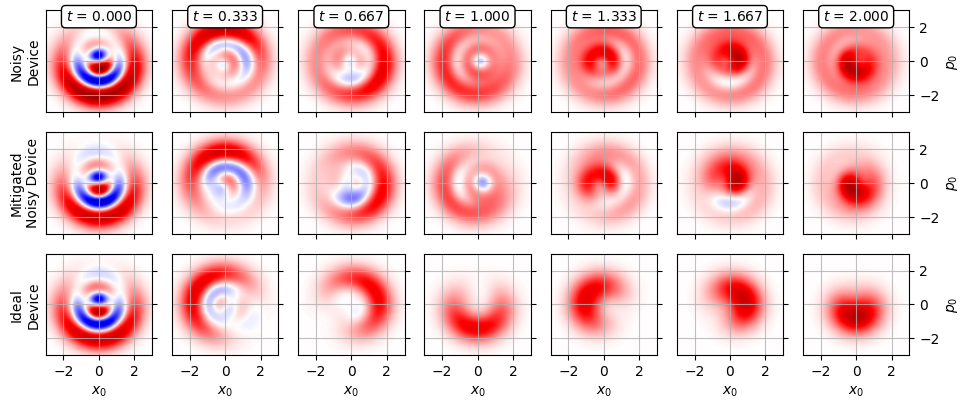

In [32]:
xp = np.linspace(-3, 3, 100)

fig, axs = plt.subplots(3,7, figsize=(1.4*7, 1.4*3))

# Noisy device
plot_wigner_trajectory(
    *cat_sim.get_wigner_distribution_trajectory(np.array(rho_noisy), xp, xp),
    t_vals=rho_t,
    axs=axs[0:1],
    t_labels=True,
    rcol_labels=True,
    t_step=2)

# Noisy device + mitigation
plot_wigner_trajectory(
    *cat_sim.get_wigner_distribution_trajectory(np.array(rho_mitigated), xp, xp),
    t_vals=rho_t,
    axs=axs[1:2],
    t_labels=False,
    rcol_labels=True,
    t_step=2)

# Ideal device
plot_wigner_trajectory(
    *cat_sim.get_wigner_distribution_trajectory(np.array(rho_simulated), xp, xp),
    t_vals=rho_t,
    axs=axs[2:3],
    t_labels=False,
    rcol_labels=True,
    t_step=2)

for ax in axs[:-1].flatten():
    ax.set_xticklabels([])
    ax.set_xlabel(None)

axs[0,0].set_ylabel('Noisy\nDevice')
axs[1,0].set_ylabel('Mitigated\nNoisy Device')
axs[2,0].set_ylabel('Ideal\nDevice')

plt.tight_layout()
plt.show()

## Experiment 2:
### Density Matrix Simulation ("Kitten" State):

In [33]:
cat_rho_t = np.linspace(*cat_t_range, n_cat_trajectory_samples)
cat_rho_t_classical = np.linspace(*cat_t_range, 1000)

### 1. Run Ideal Simulation:

In [34]:
cat_rho_simulated = cat_sim.simulate_pure_state_density_evolution(
    pure_state=initial_cat_state,
    t=cat_rho_t,
    backend=aer_backend,
    shots=n_shots,
    masking=True,
    renormalize=False,
    transpile_options=aer_transpile_options,
)

cat_rho_classical_simulated = cat_sim.simulate_classical_density_matrix_evolution(
    initial_state=initial_cat_state,
    t=cat_rho_t_classical
)

### 2. Submit Jobs:

In [35]:
# cat_rho_noisy_jobs = cat_sim.simulate_pure_state_density_evolution(
#     pure_state=initial_cat_state,
#     t=cat_rho_t,
#     backend=quantum_backend,
#     shots=n_shots,
#     masking=True,
#     renormalize=False,
#     transpile_options=quantum_transpile_options,
#     primitive_kwargs=quantum_primitive_kwargs | dict(submit_jobs_only=True)
# )

**Note**: The following cell will fail to run if you are using the Aer-based `launch_job` function, but you should still be able to run the rest of the notebook. If you have properly defined the `launch_job` function it will save the ids of submitted jobs so you can load them later on.

In [36]:
#save_data(cat_rho_noisy_jobs, 'qho_cat_job.pkl')

### 3. Retrieve Job Results: 

In [37]:
#cat_rho_noisy_jobs = load_data('qho_cat_job.pkl')

In [38]:
# cat_rho_noisy = cat_sim.simulate_pure_state_density_evolution(
#     pure_state=initial_cat_state,
#     t=cat_rho_t,
#     backend=quantum_backend,
#     shots=n_shots,
#     masking=True,
#     renormalize=False,
#     positive_definite=False,
#     transpile_options=quantum_transpile_options,
#     primitive_kwargs=quantum_primitive_kwargs | dict(submitted_jobs_data=cat_rho_noisy_jobs)
# )

In [39]:
# save_data(cat_rho_noisy, 'qho_cat_data.pkl')

### 4. Visualize Job Results:

In [40]:
cat_rho_noisy = load_data('qho_cat_data_h1_emulator.pkl')

In [41]:
from scipy.linalg import sqrtm

def twirl_parity(rho_trajectory):
    tau_diag = (-1)**np.arange(rho_trajectory[0].shape[0])
    tau = np.diag(tau_diag)

    return 0.5 * (rho_trajectory + (tau @ rho_trajectory @ tau.conj().T))

def bias_maximization(rho_trajectory, a, u=1.0):
    x = (a.conj().T + a)
    p = 1.j*(a.conj().T - a)
    x_expval = np.trace(rho_trajectory @ np.expand_dims(x, 0), axis1=-2, axis2=-1).real
    p_expval = np.trace(rho_trajectory @ np.expand_dims(p, 0), axis1=-2, axis2=-1).real
    r_expval = np.sqrt(x_expval**2 + p_expval**2)
    
    q = (x*x_expval.reshape(-1,1,1) + p*p_expval.reshape(-1,1,1))/r_expval.reshape(-1,1,1)
    
    w, U = np.linalg.eigh(q)
    w_dim = w.shape[-1]
    proj = np.zeros(w_dim)
    proj[w_dim//2:] += u
    proj[:w_dim//2] += (1-u)
    proj_diag = np.diag(proj).reshape(1,w_dim,w_dim)

    tau = np.diag((-1)**np.arange(w_dim))
    tau_w = np.transpose(U.conj(),axes=(0,2,1)) @ tau @ U
    
    q_proj_1 = U @ proj_diag @ np.transpose(U.conj(),axes=(0,2,1))
    q_proj_2 = U @ tau_w @ proj_diag @ np.transpose(U.conj(),axes=(0,2,1))

    return q_proj_1 @ rho_trajectory @ np.transpose(q_proj_1.conj(),axes=(0,2,1)) + \
           q_proj_2 @ rho_trajectory @ np.transpose(q_proj_2.conj(),axes=(0,2,1))


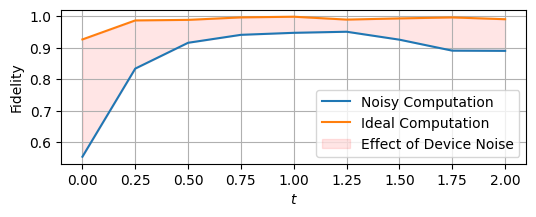

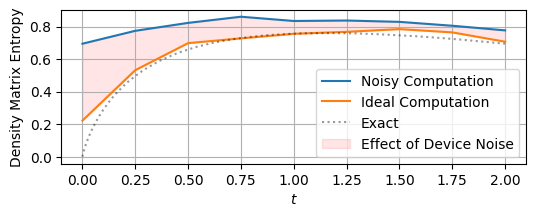

In [42]:
cat_rho_exact = cat_sim.simulate_classical_density_matrix_evolution(
    initial_state=initial_cat_state,
    t=cat_rho_t
)

cat_fidelity_noisy = fidelity(cat_rho_noisy, cat_rho_exact)
cat_fidelity_simulated = fidelity(cat_rho_simulated, cat_rho_exact)

plt.figure(figsize=(6,2))
plt.grid()
plt.plot(cat_rho_t, cat_fidelity_noisy, label='Noisy Computation')
plt.plot(cat_rho_t, cat_fidelity_simulated, label='Ideal Computation')
plt.fill_between(cat_rho_t, cat_fidelity_noisy, cat_fidelity_simulated, color='r', alpha=0.1, label='Effect of Device Noise')
plt.legend()
plt.ylabel('Fidelity')
plt.xlabel(r'$t$')
plt.show()

plt.figure(figsize=(6,2))
plt.grid()
plt.plot(cat_rho_t, entropy(cat_rho_noisy), label='Noisy Computation')
plt.plot(cat_rho_t, entropy(cat_rho_simulated), label='Ideal Computation')
plt.plot(cat_rho_t_classical, entropy(cat_rho_classical_simulated), 'k:', alpha=0.4, label='Exact')
plt.fill_between(cat_rho_t, entropy(cat_rho_simulated), entropy(cat_rho_noisy), color='r', alpha=0.1, label='Effect of Device Noise')
plt.ylabel('Density Matrix Entropy')
plt.xlabel(r'$t$')
plt.legend()
plt.show()



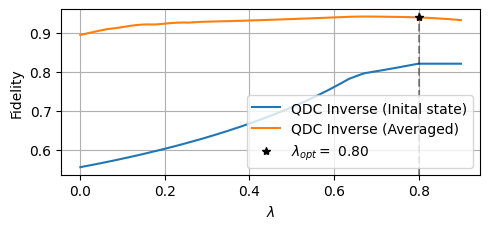

In [43]:
cat_rho_twirled = twirl_parity(cat_rho_noisy)

cat_lambda_vals = np.linspace(0.0, 0.9, 100)

cat_lambda_fidelities = np.array([
    fidelity(invert_uniform_pc(cat_rho_twirled, l),cat_rho_exact)
    for l in cat_lambda_vals
])


cat_lambda_opt_idx = np.argmax(cat_lambda_fidelities[:,0], axis=-1)
cat_lambda_opt = cat_lambda_vals[cat_lambda_opt_idx]
cat_lambda_opt_fidelities = cat_lambda_fidelities[cat_lambda_opt_idx]

plt.figure(figsize=(5,2.4))
plt.grid()
plt.plot(cat_lambda_vals, cat_lambda_fidelities[:,0], label='QDC Inverse (Inital state)')
plt.plot(cat_lambda_vals, np.mean(cat_lambda_fidelities, axis=-1), label='QDC Inverse (Averaged)')
#plt.ylim((0.6, 1.01))
plt.axvline(cat_lambda_opt, linestyle='--', color='k', alpha=0.4)
plt.plot([cat_lambda_opt],[np.mean(cat_lambda_opt_fidelities)], 'k*', label=r'$\lambda_{opt}=$ ' + f'{cat_lambda_opt:.2f}')
plt.ylabel('Fidelity')
plt.xlabel(r'$\lambda$')
plt.legend(ncol=1, loc='lower right')
plt.tight_layout()
plt.show()

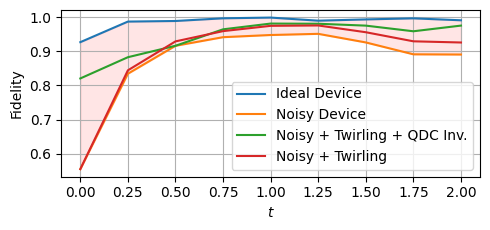

In [44]:
cat_rho_mitigated = invert_uniform_pc(twirl_parity(cat_rho_noisy), cat_lambda_opt)

plt.figure(figsize=(5,2.4))
plt.grid()
plt.plot(cat_rho_t, cat_fidelity_simulated, label='Ideal Device')
plt.plot(cat_rho_t, cat_fidelity_noisy, label='Noisy Device')
plt.plot(cat_rho_t, fidelity(cat_rho_mitigated,cat_rho_exact), label='Noisy + Twirling + QDC Inv.')
plt.plot(cat_rho_t, fidelity(cat_rho_twirled,cat_rho_exact), label='Noisy + Twirling')
plt.fill_between(cat_rho_t, cat_fidelity_noisy, cat_fidelity_simulated, color='r', alpha=0.1)
plt.legend(loc='lower right', ncol=1)
plt.ylabel('Fidelity')
plt.xlabel(r'$t$')
plt.tight_layout()
plt.show()

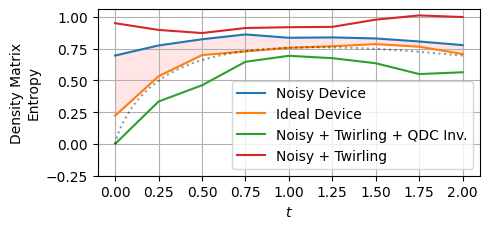

In [45]:
plt.figure(figsize=(5,2.4))
plt.grid()
plt.plot(cat_rho_t, entropy(cat_rho_noisy), label='Noisy Device')
plt.plot(cat_rho_t, entropy(cat_rho_simulated), label='Ideal Device')
plt.plot(cat_rho_t, entropy(cat_rho_mitigated), label='Noisy + Twirling + QDC Inv.')
plt.plot(cat_rho_t, entropy(cat_rho_twirled), label='Noisy + Twirling')
plt.plot(cat_rho_t_classical, entropy(cat_rho_classical_simulated), 'k:', alpha=0.4)
plt.fill_between(cat_rho_t, entropy(cat_rho_simulated), entropy(cat_rho_noisy), color='r', alpha=0.1)
plt.ylabel('Density Matrix\nEntropy')
plt.xlabel(r'$t$')
plt.legend()
plt.ylim(-0.25,None)
plt.tight_layout()
plt.show()

In [46]:
cat_X_classical = np.trace(
    cat_sim.position_operator(m=mass)@cat_rho_classical_simulated, 
    axis1=-2, axis2=-1).real

cat_P_classical = np.trace(
    cat_sim.momentum_operator(m=mass)@cat_rho_classical_simulated, 
    axis1=-2, axis2=-1).real

cat_X_noisy = np.trace(cat_sim.position_operator(m=mass)@cat_rho_noisy, 
                   axis1=-2, axis2=-1).real
cat_P_noisy = np.trace(cat_sim.momentum_operator(m=mass)@cat_rho_noisy, 
                   axis1=-2, axis2=-1).real

cat_X = np.trace(cat_sim.position_operator(m=mass)@cat_rho_simulated, axis1=-2, axis2=-1).real
cat_P = np.trace(cat_sim.momentum_operator(m=mass)@cat_rho_simulated, axis1=-2, axis2=-1).real

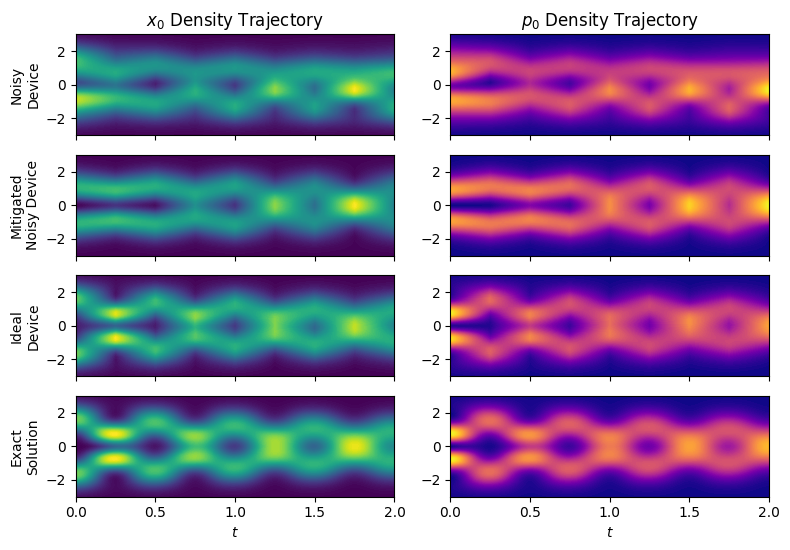

In [47]:
x_range2 = (-3,3)
p_range2 = (-3,3)

fig, axes = plt.subplots(4,2, figsize=(8,5.6))

#plt.title('Noisy Quantum Computation')
cat_sim.plot_position_density_trajectory(cat_rho_t, cat_rho_noisy, 
                                     m=mass,
                                     xlim=x_range2,
                                     cmap='viridis',
                                     ax=axes[0,0],
                                     unitless=True)

#plt.title('Mitigated Quantum Computation')
cat_sim.plot_position_density_trajectory(cat_rho_t, cat_rho_mitigated, 
                                     m=mass,
                                     xlim=x_range2,
                                     cmap='viridis',
                                     ax=axes[1,0],
                                     unitless=True)

#plt.title('Ideal Quantum Computation')
cat_sim.plot_position_density_trajectory(cat_rho_t, cat_rho_simulated, 
                                     m=mass,
                                     xlim=x_range2,
                                     cmap='viridis',
                                     ax=axes[2,0],
                                     unitless=True)



#plt.title('Exact Lindblad Solution')
cat_sim.plot_position_density_trajectory(cat_rho_t_classical, cat_rho_classical_simulated,
                                     m=mass,
                                     xlim=x_range2,
                                     cmap='viridis',
                                     ax=axes[3,0],
                                     unitless=True)

#plt.title('Noisy Quantum Computation')
cat_sim.plot_momentum_density_trajectory(cat_rho_t, cat_rho_noisy, 
                                     m=mass,
                                     plim=p_range2,
                                     ax=axes[0,1],
                                     unitless=True)

#plt.title('Mitigated Quantum Computation')
cat_sim.plot_momentum_density_trajectory(cat_rho_t, cat_rho_mitigated, 
                                     m=mass,
                                     plim=p_range2,
                                     ax=axes[1,1],
                                     unitless=True)

#plt.title('Ideal Quantum Computation')
cat_sim.plot_momentum_density_trajectory(cat_rho_t, cat_rho_simulated, 
                                     m=mass,
                                     plim=p_range2,
                                     ax=axes[2,1],
                                     unitless=True)


#plt.title('Exact Lindblad Solution')
cat_sim.plot_momentum_density_trajectory(cat_rho_t_classical, cat_rho_classical_simulated,
                                     m=mass,
                                     plim=p_range2,
                                     ax=axes[3,1],
                                     unitless=True)


for ax in axes[:-1,0]:
    ax.set_xticklabels([])
    ax.set_xlabel(None)
for ax in axes[:-1,1]:
    ax.set_xticklabels([])
    ax.set_xlabel(None)

axes[0,0].set_ylabel('Noisy\nDevice')
axes[1,0].set_ylabel('Mitigated\nNoisy Device')
axes[2,0].set_ylabel('Ideal\nDevice')
axes[3,0].set_ylabel('Exact\nSolution')
for ax in axes[:,1]:
    ax.set_ylabel(None)

axes[0,0].set_title('$x_0$ Density Trajectory')
axes[0,1].set_title('$p_0$ Density Trajectory')

plt.tight_layout()
plt.show()

In [48]:
# ideal_cat_anim = cat_sim.plot_wigner_distribution_animation(cat_rho_t, np.array((cat_rho_simulated)),
#                                                   xlim=(-3.5,3.5), plim=(-3.5,3.5),
#                                                   mesh_size=(50,50),
#                                                   frame_interval=1000)
# plt.title('Ideal Cat State')

In [49]:
# noisy_cat_anim = cat_sim.plot_wigner_distribution_animation(cat_rho_t, np.array(cat_rho_mitigated),
#                                                   xlim=(-3.5,3.5),
#                                                   plim=(-3.5,3.5),
#                                                   mesh_size=(50,50),
#                                                   frame_interval=1000)

# plt.title('Noisy Cat State')

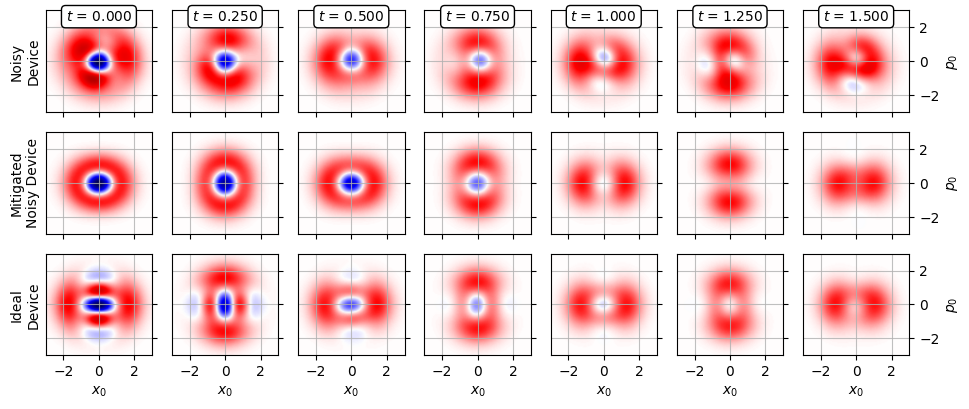

In [50]:
xp = np.linspace(-3, 3, 100)

fig, axs = plt.subplots(3,7, figsize=(1.4*7, 1.4*3))

# Noisy device
plot_wigner_trajectory(
    *cat_sim.get_wigner_distribution_trajectory(np.array(cat_rho_noisy), xp, xp),
    t_vals=cat_rho_t,
    axs=axs[0:1],
    t_labels=True,
    rcol_labels=True,
    t_step=1)

# Noisy device + mitigation
plot_wigner_trajectory(
    *cat_sim.get_wigner_distribution_trajectory(np.array(cat_rho_mitigated), xp, xp),
    t_vals=cat_rho_t,
    axs=axs[1:2],
    t_labels=False,
    rcol_labels=True,
    t_step=1)

# Ideal device
plot_wigner_trajectory(
    *cat_sim.get_wigner_distribution_trajectory(np.array(cat_rho_simulated), xp, xp),
    t_vals=cat_rho_t,
    axs=axs[2:3],
    t_labels=False,
    rcol_labels=True,
    t_step=1)

for ax in axs[:-1].flatten():
    ax.set_xticklabels([])
    ax.set_xlabel(None)

axs[0,0].set_ylabel('Noisy\nDevice')
axs[1,0].set_ylabel('Mitigated\nNoisy Device')
axs[2,0].set_ylabel('Ideal\nDevice')

# for i in range(axs.shape[-1]):
#     for ax in axs[:,i]:
#         if i & 1:
#             ax.axvline(0, color='k', linestyle=':')

plt.tight_layout()
plt.show()